# PACKEGES & LIBRARIES

In [1]:
import os

import math
import matplotlib.pyplot as plt
import numpy as np

from skimage import io, transform, color, img_as_float, img_as_float64, img_as_ubyte
from scipy.ndimage import gaussian_filter
from skimage.filters import gaussian, rank
from skimage.morphology import disk

import warnings
warnings.filterwarnings("ignore")

# plt.rcParams['figure.figsize'] = [15, 5]

SPAN = 15

# FUNCTION

In [2]:
def reconstruct_rgb_by_single_ycbcr_ch(y, cb, cr):
    ycbcbr_img = np.stack((y, cb, cr), axis=-1)
    rgb_img = color.ycbcr2rgb(ycbcbr_img)
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min()) # applying min-max norm to avoid plt warning
                                                                          # due to scale mismatch of values which forces to clipping

    return img_as_float(rgb_img)

In [3]:
def show_img(img, colmap=False, dict_title=None):

    if isinstance(img, list):
        num_images = len(img)
        max_per_row = 3
        num_rows = math.ceil(num_images / max_per_row)
        plt.figure(figsize=(5 * max_per_row, 5 * num_rows))

        if dict_title and len(dict_title) != num_images:
            print("Warning: The number of titles does not match the number of images.")
            dict_title = None

        for i, single_img in enumerate(img, 1):
            plt.subplot(num_rows, max_per_row, i)
            if colmap:
                plt.imshow(single_img, norm='linear', cmap='gray')
            else:
                plt.imshow(single_img, norm='linear')
            plt.subplots_adjust(wspace=0.3, hspace=-0.3)

            title = dict_title.get(i, f"Image n. {i}") if dict_title else f"Image n. {i}"
            plt.title(title)

    else:
        plt.figure(figsize=(15, 5))
        if colmap:
            plt.imshow(img, norm='linear', cmap='gray')
        else:
            plt.imshow(img, norm='linear')
        plt.title("Custom image")
        if dict_title:
            plt.title(dict_title)

    plt.show()

# MAIN

First, I load a specific image saved by google images. Then, by using `skimage.color.convert_colorspace`, the image originally mapped in **RGB** color space, is going to be mapped in the new **YCbCr** domain.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
mn_rgb = io.imread(os.path.join('./drive/MyDrive/Images/mountains.jpg'))
# mn_ycbcr = color.convert_colorspace(mn_rgb, 'RGB', 'YCbCr')
mn_ycbcr = color.rgb2ycbcr(mn_rgb)

In order to plot the YCbCr image recalling `matplotlib` methods, an 'int' casting to array values is performed as floats do not be supported if not scaled into the [0,1] range.

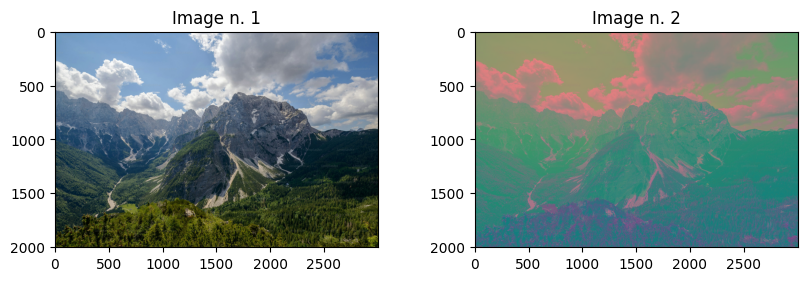

In [6]:
mn_ycbcr_int = mn_ycbcr.astype(int) # 'int' casting
show_img([mn_rgb, mn_ycbcr_int])

The above graph is just the comparison of the two color spaces: while the original is mapped in RGB space by default, the second is made by overlapping each of the 3 color-channel, namely the **Luma** (Y) channel - a kind of grayscale mapping - and both the **chroma** channels (Cb and Cr).

Let's now compare the shapes of the two different color-domain images:

In [7]:
print("Shape of rgb img: ", mn_rgb.shape)
print("Shape of ycbcr img: ", mn_ycbcr.shape)

Shape of rgb img:  (2002, 3000, 3)
Shape of ycbcr img:  (2002, 3000, 3)


It can be noticed that no transformation regarding array dimensions it has been performed.<br>
Color channels are either of the same amount (three).

## Y-Cb-Cr image exploration

Let's now split each of the YCbCr channels, in order to plot them one by one.

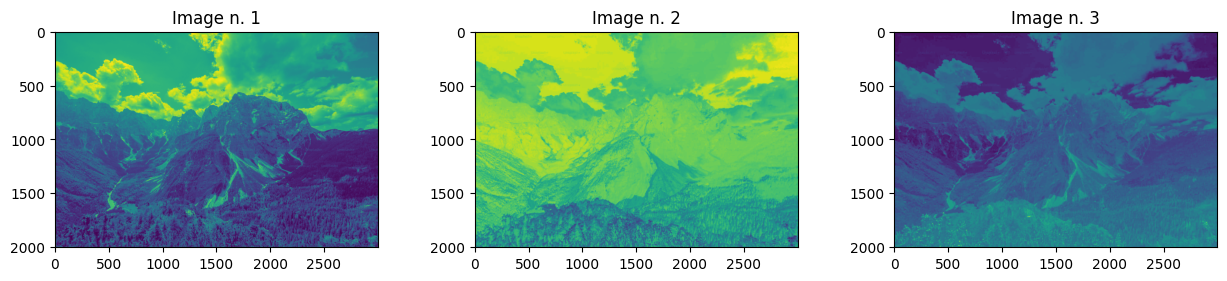

In [8]:
show_img([mn_ycbcr[:, :, 0],mn_ycbcr[:, :, 1],mn_ycbcr[:, :, 2]])

Let's plot the same single-channel YCbCr images, by applying the grayscale color map

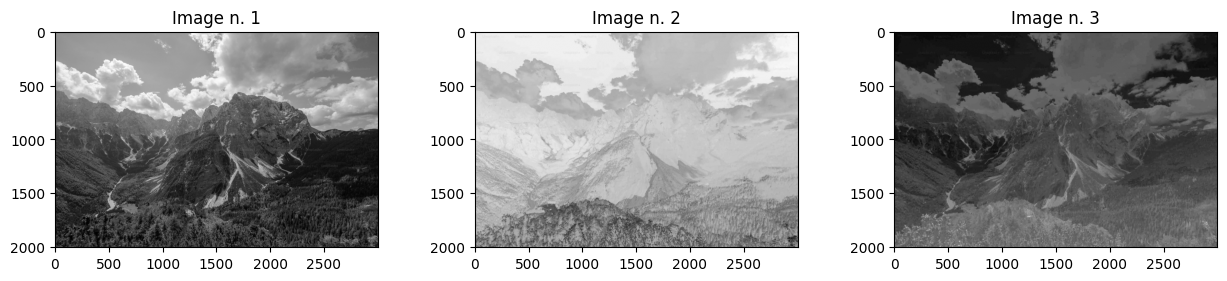

In [9]:
show_img([mn_ycbcr[:, :, 0],mn_ycbcr[:, :, 1],mn_ycbcr[:, :, 2]], colmap=True)

In [10]:
mn_ycbcr[:, :, 0] # example of single 2D matrix, by choosing Luma channel-valued pixels

array([[137.34317647, 138.202     , 139.06082353, ...,  91.46052941,
         91.46052941,  91.46052941],
       [136.48435294, 137.34317647, 139.06082353, ...,  91.46052941,
         91.46052941,  91.46052941],
       [136.48435294, 137.34317647, 138.202     , ...,  91.46052941,
         91.46052941,  91.46052941],
       ...,
       [ 74.327     ,  82.01003529, 125.05427059, ...,  30.70477647,
         75.12484706,  74.28062353],
       [ 89.96274118,  95.65674118,  96.80928235, ...,  36.78267059,
         43.98562353,  59.96317647],
       [ 90.55532941,  83.21754118,  74.5022    , ...,  33.17389412,
         40.97888235,  56.64811765]])

By extracting the single channel-index, it is possibile to plot a 2D numpy.array, where each single pixel is mapped onto it.

## Gaussian filter

In [11]:
cb_only = mn_ycbcr[:,:,1] # extracting 'Cb' channel
cr_only = mn_ycbcr[:,:,2] # extracting 'Cr' channel

Let's now build the blurred channel-specific image, by chosing sigma=10.<br>
By reading `skimage` documentation, `gaussian` method implemented by `filters` class wraps `scipy.ndimage.gaussian_filter()` function: as it provides more paramaters to be defined, I decide to use the source code for processing.<br>
The two code cells below are related to some trials of performing gaussian filter on **chroma** channels, with different values of *sigma*.

In [12]:
cb_only_gf_1a = gaussian_filter(cb_only, sigma=3); cr_only_gf_1a = gaussian_filter(cr_only, sigma=3)
cb_only_gf_1b = gaussian_filter(cb_only, sigma=5); cr_only_gf_1b = gaussian_filter(cr_only, sigma=5)
cb_only_gf_1c = gaussian_filter(cb_only, sigma=9); cr_only_gf_1c = gaussian_filter(cr_only, sigma=9)
cb_only_gf_1d = gaussian_filter(cb_only, sigma=15); cr_only_gf_1d = gaussian_filter(cr_only, sigma=15)
cb_only_gf_1e = gaussian_filter(cb_only, sigma=20); cr_only_gf_1e = gaussian_filter(cr_only, sigma=20)
cb_only_gf_1f = gaussian_filter(cb_only, sigma=30); cr_only_gf_1f = gaussian_filter(cr_only, sigma=30)

In order to display how blurred images appear by using different **sigma** values, I plot some examples of **Cb** processed-image only among the six different choices of value.<br>
The same blurred effect among different magnitude would be expected by applying same gaussian filters over Cr channel.

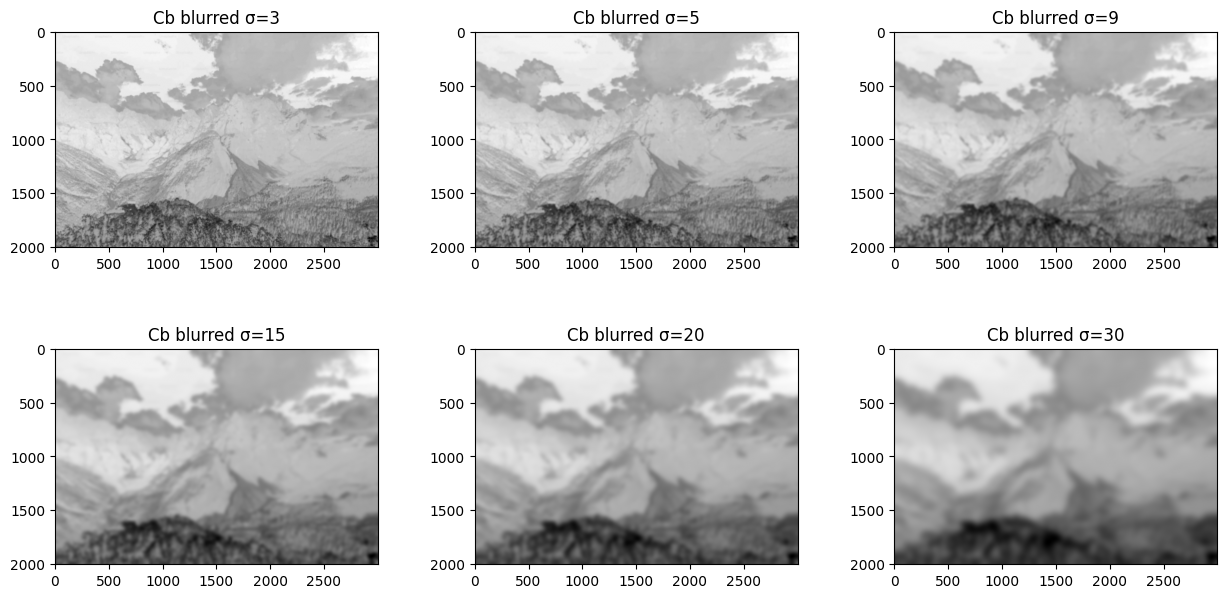

In [13]:
subplot_titles = {
    1: "Cb blurred σ=3",
    2: "Cb blurred σ=5",
    3: "Cb blurred σ=9",
    4: "Cb blurred σ=15",
    5: "Cb blurred σ=20",
    6: "Cb blurred σ=30"
}

show_img([cb_only_gf_1a,cb_only_gf_1b,
          cb_only_gf_1c,cb_only_gf_1d,
          cb_only_gf_1e,cb_only_gf_1f],
          colmap=True,
          dict_title=subplot_titles)

As it can be revealed by plots, the greater the values of **sigma**, the greater the effect of filter blurring.<br>
About **radius** parameter which manages the kernel size:
* if specified, radius takes a value equal to (2*k + 1), with k=custom value;
* otherwise, it takes the default value of (4*σ).

For the aim of the asseignement, parameters which leads to *1b* and *1f*  will be taken into account.

In [14]:
print(cr_only); print("---"*SPAN*3, '\n'); print(cr_only_gf_1f)

[[105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 [105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 [105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 ...
 [132.43915294 131.84643137 130.51813333 ... 128.55011765 131.85708235
  131.84643137]
 [129.80385882 128.78257255 128.5682902  ... 127.87531765 128.88595294
  128.50751373]
 [128.11842353 127.83271373 127.92544314 ... 127.37532549 127.9467451
  127.79323922]]
--------------------------------------------------------------------------------------------------------------------------------------- 

[[106.07552715 106.0758092  106.07637284 ... 108.042217   108.04221254
  108.04221189]
 [106.07566205 106.07594445 106.0765088  ... 108.04239182 108.04238785
  108.04238745]
 [106.0759312  106.07621431 106.07678007 ... 108.04273996 108.04273698
  108.04273707]
 ...
 [128.78410826 128.78456629 128.78548224 ... 127.04482797 127.0416862

Above it can be noticed how filter acts, with the smoothing behavior especially towards the right-down values: from [119, 104, 101, 116, 112, 109, 119, 115, 113] -> [112,...,112].

## Reconstructing the image after blurring

### Chroma blur

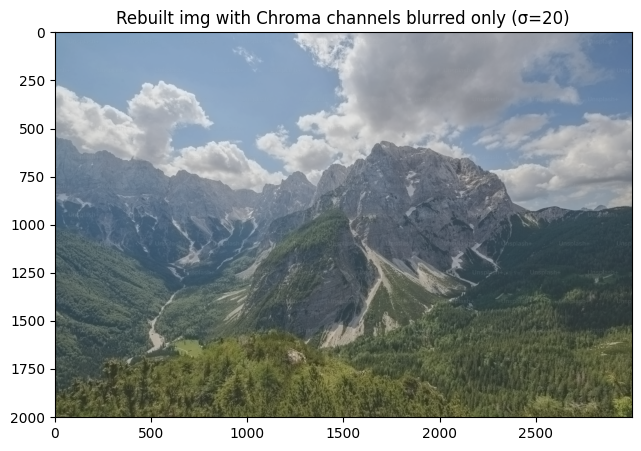

In [15]:
rgb_rebuilt_img_chroma_blr_sig20 = reconstruct_rgb_by_single_ycbcr_ch(
                mn_ycbcr[:,:,0],
                cb_only_gf_1e,
                cr_only_gf_1e)

show_img(rgb_rebuilt_img_chroma_blr_sig20, dict_title='Rebuilt img with Chroma channels blurred only (σ=20)')

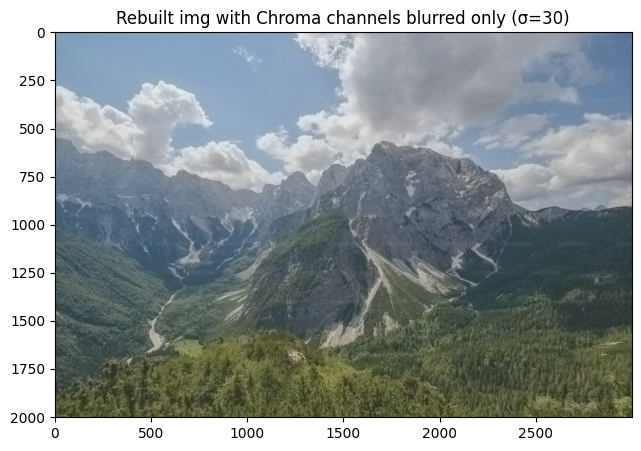

In [16]:
rgb_rebuilt_img_chroma_blr_sig30 = reconstruct_rgb_by_single_ycbcr_ch(
                mn_ycbcr[:,:,0],
                cb_only_gf_1f,
                cr_only_gf_1f)

show_img(rgb_rebuilt_img_chroma_blr_sig30, dict_title='Rebuilt img with Chroma channels blurred only (σ=30)')

It can be noticed that, by applying blurring effect on **chroma** and backing into RGB color space from YCbCr id does not seem to have any visual effect on image distorsion, as the image appears to be the same as the original, even if a large value of sigma is chosen.<br>

Let's now take a look on the image aftwer blurring **Luma** channel.

### Luma blur

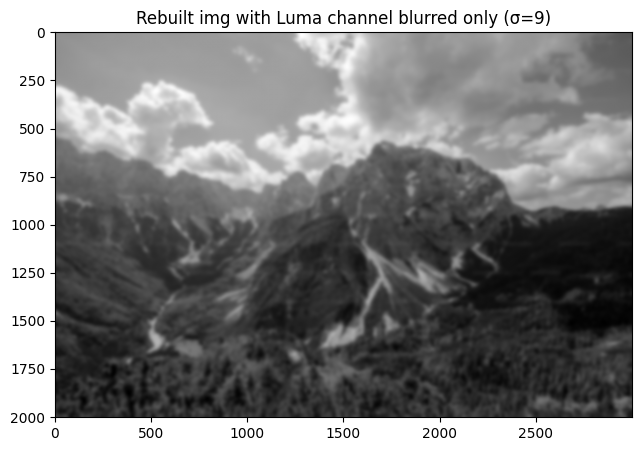

In [17]:
Y_blurred_sig9 = gaussian_filter(mn_ycbcr[:,:,0], sigma=9)
show_img(Y_blurred_sig9, colmap=True, dict_title='Rebuilt img with Luma channel blurred only (σ=9)')

On the contrary with respect of **chroma** manipulation, yet an intermediate size of sigma between those which have been taken into account previously, leads to an eligible blurring effect.

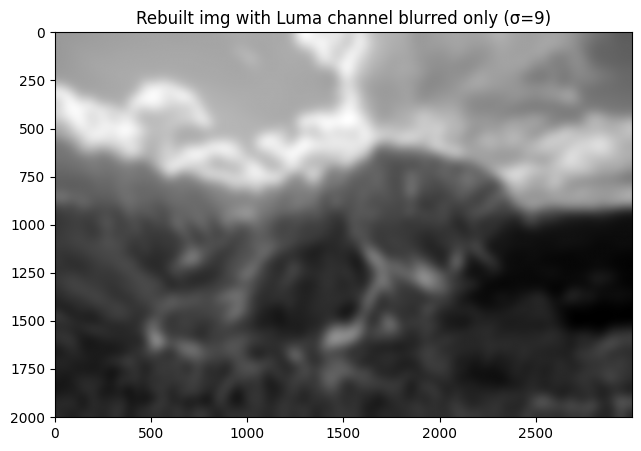

In [18]:
Y_blurred_sig30 = gaussian_filter(mn_ycbcr[:,:,0], sigma=30)
show_img(Y_blurred_sig30, colmap=True, dict_title='Rebuilt img with Luma channel blurred only (σ=9)')

The larger the sigma, the worse the image perceived resolution after blurring.

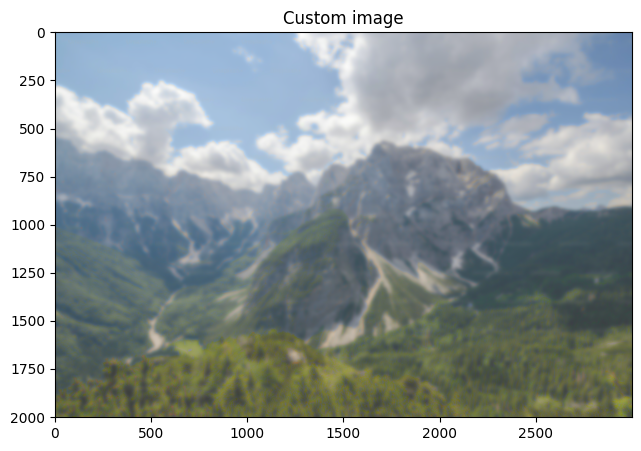

In [19]:
rgb_rebuilt_img_luma_blr = reconstruct_rgb_by_single_ycbcr_ch(
                Y_blurred_sig9, cb_only, cr_only)

show_img(rgb_rebuilt_img_luma_blr)

Here above is just a trial in order to visualize the effect after reconstructing the image with all the 3 channel blurred. No differences between it and the previous one (only luma blurred) is detected, demonstrating that blurring effect comes from **Luma** manipulation.